<a href="https://colab.research.google.com/github/alisa0040/Weather-Temperature-Prediction-LSTM/blob/main/temperature_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,BatchNormalization,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Download latest version
path = kagglehub.dataset_download("alistairking/weather-long-term-time-series-forecasting")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-long-term-time-series-forecasting


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

path = "/kaggle/input/weather-long-term-time-series-forecasting"

df = pd.read_csv(f"{path}/cleaned_weather.csv")

df.head()

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


In [8]:
df.shape

(52696, 21)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52696 entries, 0 to 52695
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      52696 non-null  object 
 1   p         52696 non-null  float64
 2   T         52696 non-null  float64
 3   Tpot      52696 non-null  float64
 4   Tdew      52696 non-null  float64
 5   rh        52696 non-null  float64
 6   VPmax     52696 non-null  float64
 7   VPact     52696 non-null  float64
 8   VPdef     52696 non-null  float64
 9   sh        52696 non-null  float64
 10  H2OC      52696 non-null  float64
 11  rho       52696 non-null  float64
 12  wv        52696 non-null  float64
 13  max. wv   52696 non-null  float64
 14  wd        52696 non-null  float64
 15  rain      52696 non-null  float64
 16  raining   52696 non-null  float64
 17  SWDR      52696 non-null  float64
 18  PAR       52696 non-null  float64
 19  max. PAR  52696 non-null  float64
 20  Tlog      52696 non-null  fl

In [10]:
df.columns

Index(['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh',
       'H2OC', 'rho', 'wv', 'max. wv', 'wd', 'rain', 'raining', 'SWDR', 'PAR',
       'max. PAR', 'Tlog'],
      dtype='object')

In [11]:
df.set_index('date', inplace=True)

In [12]:
print("Duplicate timestamps:", df.index.duplicated().sum())

Duplicate timestamps: 1


In [13]:
df = df[~df.index.duplicated()]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

scaled_df.head()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,2.052840,-1.353486,-1.525204,-1.131385,0.707921,-1.055596,-1.028198,-0.707712,-1.050636,-1.051386,1.914343,-0.022386,-0.825536,0.584404,-0.095494,-0.232351,-0.608769,-0.614649,-0.541452,-1.292018
2020-01-01 00:20:00,2.038720,-1.348130,-1.519953,-1.149852,0.661120,-1.052976,-1.040625,-0.696880,-1.062348,-1.061183,1.906383,-0.035919,-1.134172,0.368872,-0.095494,-0.232351,-0.608769,-0.614649,-0.541452,-1.284316
2020-01-01 00:30:00,2.027859,-1.350808,-1.521266,-1.156567,0.655919,-1.054286,-1.043111,-0.695075,-1.062348,-1.066082,1.905285,-0.031790,-0.874268,0.249406,-0.095494,-0.232351,-0.608769,-0.614649,-0.541452,-1.272764
2020-01-01 00:40:00,2.025687,-1.399011,-1.567217,-1.183428,0.718322,-1.076558,-1.060509,-0.713128,-1.077964,-1.080779,1.951401,-0.020321,-0.874268,0.363946,-0.095494,-0.232351,-0.608769,-0.614649,-0.541452,-1.259928
2020-01-01 00:50:00,2.022429,-1.404366,-1.572468,-1.159925,0.775524,-1.077868,-1.045596,-0.725765,-1.066252,-1.068532,1.954421,-0.034543,-0.906756,0.403357,-0.095494,-0.232351,-0.608769,-0.614649,-0.541452,-1.245808


In [15]:
import os

In [17]:
import numpy as np
# 24 hours window
def create_sequences(data, target_column, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_column])
    return np.array(X), np.array(y)

data_array = scaled_df.values


target_col = scaled_df.columns.get_loc('T')

X, y = create_sequences(data_array, target_col, window_size=144)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (52551, 144, 20)
y shape: (52551,)


In [18]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (42040, 144, 20) (42040,)
Validation shape: (5255, 144, 20) (5255,)
Test shape: (5256, 144, 20) (5256,)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_lstm_model(input_shape):
    model = Sequential()

    model.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))

    model.add(LSTM(units=64, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(units=32, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(units=16, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(LayerNormalization())

    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    return model

model = create_lstm_model(X_train.shape[1:])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

model.save("/content/drive/MyDrive/weather_lstm_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 538s 403ms/step - loss: 0.1522 - mae: 0.2653 - val_loss: 0.0123 - val_mae: 0.0815
Epoch 2/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 540s 386ms/step - loss: 0.0244 - mae: 0.1178 - val_loss: 0.0199 - val_mae: 0.1038
Epoch 3/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 571s 394ms/step - loss: 0.0190 - mae: 0.1039 - val_loss: 0.0104 - val_mae: 0.0772
Epoch 4/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 525s 399ms/step - loss: 0.0158 - mae: 0.0943 - val_loss: 0.0095 - val_mae: 0.0783
Epoch 5/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 560s 398ms/step - loss: 0.0149 - mae: 0.0914 - val_loss: 0.0194 - val_mae: 0.1221
Epoch 6/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 554s 392ms/step - loss: 0.0126 - mae: 0.0838 - val_loss: 0.0068 - val_mae: 0.0694
Epoch 7/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 520s 396ms/step - loss: 0.0118 - mae: 0.0810 - val_loss: 0.0057 - val_mae: 0.0622
Epoch 8/50
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 529s 403ms/step - loss: 0.0117 - mae: 0.0800 - val_loss: 0.0127 - val_mae: 0.0827
Epoch 9/

Test Loss: 0.009656138718128204, Test MAE: 0.09258537739515305


In [20]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))

165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step
R²: 0.9387158715987373


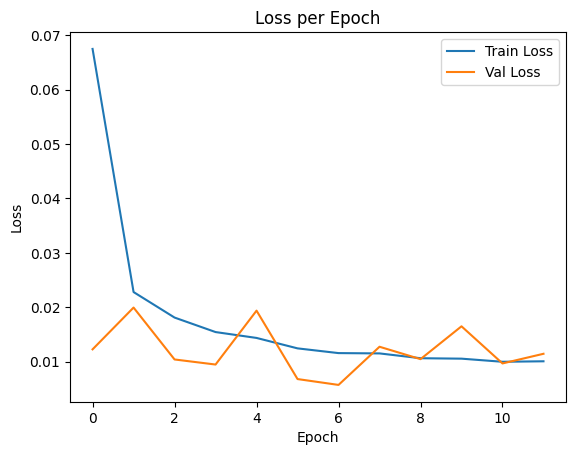

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 144, 128)       │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 144, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 144, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,893 (1.62 MB)

 Trainable params: 141,297 (551.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 282,596 (1.08 MB)